In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [11]:
import pandas as pd

# Load the Excel file (replace with the filename you uploaded)
df = pd.read_excel("/content/drive/MyDrive/Hackathon/Didul - Random forest/updated_with_prev_production(Maha).xlsx")

df.head()

,Year,District,Sown(hect),Extent Harvested(hect),Yield(kg per hect),Total production(mt.),Season,Season_encoded,District_encoded,Previous_Yield,Previous_Production
0,1979.0,AMPARA,44037.0,41779,3124.0,29300.0,Maha,0.0,0.0,NaN,NaN
1,1980.0,AMPARA,41056.0,40609,3597.0,30100.0,Maha,0.0,0.0,3124.0,29300.0
2,1981.0,AMPARA,48835.0,48638,4253.0,30600.0,Maha,0.0,0.0,3597.0,30100.0
3,1982.0,AMPARA,47587.0,41433,3893.0,32200.0,Maha,0.0,0.0,4253.0,30600.0
4,1983.0,AMPARA,49356.0,46702,4339.0,43100.0,Maha,0.0,0.0,3893.0,32200.0


In [ ]:
import numpy as np

# Step 1: Clean the 'Year' column (e.g., "1978/1979" → 1979), handling NaNs
def clean_year(value):
    if pd.isna(value):
        return np.nan
    try:
        return int(str(value).split('/')[-1])
    except (ValueError, IndexError):
        return np.nan

df['Year_cleaned'] = df['Year'].apply(clean_year)

In [12]:
# Fix Year column by extracting first year as integer
# df['Year'] = df['Year'].apply(lambda x: int(str(x).split('/')[0]))

# Encode categorical columns
df['Season_encoded'] = LabelEncoder().fit_transform(df['Season'])
df['District_encoded'] = LabelEncoder().fit_transform(df['District'])

# Define features and target
# features = ['Year', 'Season_encoded', 'District_encoded', 'Yield(kg per hect)', 'Extent Harvested(hect)', 'Sown(hect)']
features = ['Year', 'Season_encoded', 'District_encoded', 'Sown(hect)', 'Previous_Production']
target = 'Total production(mt.)'

In [13]:
# Drop rows with missing values in features or target
df_clean = df.dropna(subset=features + [target])

X = df_clean[features]
y = df_clean[target]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Train model
!pip install lightgbm catboost

from catboost import CatBoostRegressor

# model_extent = CatBoostRegressor(
#     iterations=100000,       # high upper limit
#     early_stopping_rounds=100,  # stop if no improvement for 100 rounds
#     verbose=100,
#     random_state=42
# )

# model_extent = CatBoostRegressor(
#     iterations=20000,
#     depth=12,
#     learning_rate=0.2,
#     l2_leaf_reg=12,
#     bagging_temperature=1,
#     early_stopping_rounds=100,
#     verbose=100,
#     random_state=42
# )

# !pip install lightgb

# from lightgbm import LGBMRegressor

# model_extent = LGBMRegressor(
#    n_estimators=100,
#    max_depth=10,
#    learning_rate=0.1,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    random_state=42
# )

!pip install xgboost

from xgboost import XGBRegressor

model_extent = XGBRegressor(
   n_estimators=100,
   max_depth=10,
   learning_rate=0.1,
   subsample=0.8,
   colsample_bytree=0.8,
   random_state=42
)

# model_extent = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=30,
#     min_samples_leaf=1,
#     min_samples_split=2,
#     random_state=42
# )

model_extent.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [15]:
import joblib
from google.colab import files

# Save models and mappings
joblib.dump(model_extent, "model_production(Maha).pkl")
# joblib.load("model_prodiction.pkl")

# Download from Colab
files.download("model_production(Maha).pkl")
# files.download("model_extent.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model_extent.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 15911.135134055397
R² Score: 0.8960654251738359


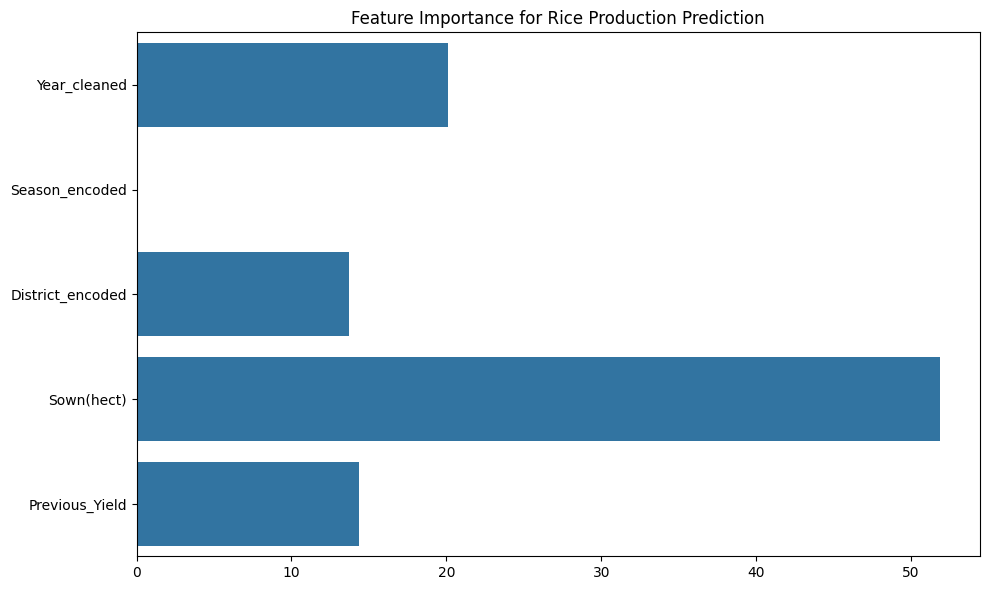

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model_extent.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance for Rice Production Prediction")
plt.tight_layout()
plt.show()

In [ ]:
import joblib
import pandas as pd
from google.colab import files

# Load the saved models
# uploaded = files.upload()

# Load the Excel file (replace with the filename you uploaded)
# file_name = next(iter(uploaded))
# model_prediction = joblib.load("model_prediction.pkl")

# Static mappings (adjust if needed)
season_map = {'Maha': 0, 'Yala': 1}
district_list = df['District'].unique().tolist()

def predict_production(year, season, district, sown_hect, previous_yield):
    """
    Predict total rice production using pretrained models.
    Adjusts for unit conversion to match real-world production scale.

    Returns:
    - predicted_production_million_metric_tons
    - predicted_extent
    - predicted_yield
    """
    # Encode inputs
    season_encoded = season_map.get(season, 0)
    try:
        district_encoded = district_list.index(district.upper())
    except ValueError:
        raise ValueError(f"District '{district}' not found in the dataset.")

    # Create input DataFrame
    input_df = pd.DataFrame([{
        'Year_cleaned': year,
        'Season_encoded': season_encoded,
        'District_encoded': district_encoded,
        'Sown(hect)': sown_hect,
        'Previous_Production': previous_yield
    }])

    # Predict Harvested Extent
    predicted_extent = model_extent.predict(
        input_df[['Year_cleaned', 'Season_encoded', 'District_encoded', 'Sown(hect)', 'Previous_Production']]
    )[0]

    return round(predicted_extent, 2)

In [ ]:
extent = predict_production(
    year=1999,
    season='Yala',
    district='POLONNARUWA',
    sown_hect=46144,
    previous_yield=4335
    # year=1982,
    # season='Yala',
    # district='BADULLA',
    # sown_hect=4369
)

print(f"Predicted Harvested Extent: {extent} hectares")

In [ ]:
features1 = ['Year_cleaned', 'Season_encoded', 'District_encoded', 'Extent Harvested(hect)', 'Previous_Yield']
target1 = 'Total production(mt.)'

# Drop rows with missing values in features or target
df_clean = df.dropna(subset=features + [target])

X = df_clean[features1]
y = df_clean[target1]

# Print the features used for training to verify
print("Features used for training model_prodiction:", features1)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Features used for training model_prodiction: ['Year_cleaned', 'Season_encoded', 'District_encoded', 'Extent Harvested(hect)', 'Previous_Yield']


In [ ]:
import joblib

# Train model
model_prodiction = CatBoostRegressor(
    iterations=20000,
    depth=12,
    learning_rate=0.2,
    l2_leaf_reg=12,
    bagging_temperature=1,
    early_stopping_rounds=100,
    verbose=100,
    random_state=42
)

# model_prodiction = LGBMRegressor(
#    n_estimators=100,
#    max_depth=10,
#    learning_rate=0.1,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    random_state=42
# )

# model_prodiction = XGBRegressor(
#    n_estimators=100,
#    max_depth=10,
#    learning_rate=0.1,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    random_state=42
# )

# model_prodiction = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=30,
#     min_samples_leaf=1,
#     min_samples_split=2,
#     random_state=42
# )

model_prodiction.fit(X_train, y_train)

# Save models and mappings
# joblib.dump(model_prodiction, "model_prodiction.pkl")
# Download from Colab
# files.download("model_prodiction.pkl")

NameError: name 'CatBoostRegressor' is not defined

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model_extent.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 13369.890358127175
R² Score: 0.9237430260437083


In [19]:
import joblib
import pandas as pd
from google.colab import files

# Load the saved production model
# Assuming the model_prodiction.pkl is already uploaded or saved to the Colab environment
try:
    model_production = joblib.load("model_production.pkl")
except FileNotFoundError:
    print("model_prodiction.pkl not found. Please ensure the model is saved and accessible.")
    # You might want to add a mechanism to upload the file here if it's not found

# Static mappings (adjust if needed)
season_map = {'Maha': 0, 'Yala': 1}
district_list = df['District'].unique().tolist()

def predict_production1(year, season, district, sown_hect, previous_production):
    """
    Predict total rice production using pretrained models.
    Adjusts for unit conversion to match real-world production scale.

    Returns:
    - predicted_production_million_metric_tons
    - predicted_extent
    - predicted_yield
    """
    # Encode inputs
    season_encoded = season_map.get(season, 0)
    try:
        district_encoded = district_list.index(district.upper())
    except ValueError:
        raise ValueError(f"District '{district}' not found in the dataset.")

    # last year extracted
    if isinstance(year, str) and "/" in year:
        last_year = int(year.split("/")[-1])
    else:
        last_year = int(year)  # If already a single year

    # Create input DataFrame with correct feature names
    input_df = pd.DataFrame([{
        'Year': last_year,
        'Season_encoded': season_encoded,
        'District_encoded': district_encoded,
        'Sown(hect)': sown_hect,
        'Previous_Production': previous_production # Use the correct feature name
    }])

    # Predict Harvested Production
    predicted_production = model_production.predict(
        input_df[['Year', 'Season_encoded', 'District_encoded', 'Sown(hect)', 'Previous_Production']] # Use the correct feature names
    )[0]

    return round(predicted_production, 2)

model_prodiction.pkl not found. Please ensure the model is saved and accessible.


In [20]:
production = predict_production1(
    year=2023/2024,
    season='Maha',
    district='VAVUNIYA',
    sown_hect=23412,
    previous_production=2861
)

print(f"Predicted Harvested Extent: {production} hectares")

Predicted Harvested Extent: 50568.51 hectares


In [21]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Prepare feature set
X_extent_harvested = df[['Year', 'Season_encoded', 'District_encoded', 'Sown(hect)', 'Previous_Production']]

# Step 2: Predict production using the extent model
df['Predicted_Production'] = model_extent.predict(X_extent_harvested)

# Step 3: Drop rows with NaNs in either actual or predicted columns
df_clean = df.dropna(subset=['Total production(mt.)', 'Predicted_Production'])

# Step 4: Evaluate predictions
y_true = df_clean['Total production(mt.)']
y_pred = df_clean['Predicted_Production']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Evaluation on Cleaned Test Set:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

Evaluation on Cleaned Test Set:
MAE: 5708.53
RMSE: 17210.94
R²: 0.9606


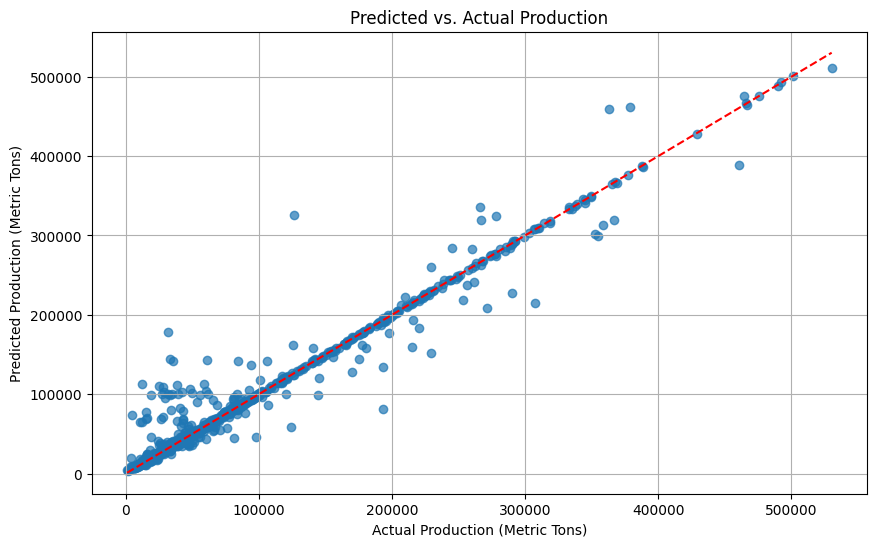

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # perfect line
plt.xlabel("Actual Production (Metric Tons)")
plt.ylabel("Predicted Production (Metric Tons)")
plt.title("Predicted vs. Actual Production")
plt.grid(True)
plt.show()